In [5]:
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torchtext
from torchtext.data.utils import get_tokenizer

import seaborn as sns

sns.set(palette="Set2")
sns.set_style("whitegrid")

import nltk

nltk.download("stopwords")

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/salary_dataset.csv")
dataset.head()

,FullDescription,SalaryNormalized
0,This is an exciting opportunity for a Recruite...,55000
1,Our client is looking for a .net web developer...,27500
2,"MS SQL Database Administrator Helsinki, Finla...",72098
3,ACADEMIC APPOINTMENTS A large secondary school...,32400
4,Head of User Experience c. ****k / London A H...,67500


In [ ]:
dataset.iloc[0]["FullDescription"]

'This is an exciting opportunity for a Recruiter to join a rapidly growing online retailer. You will be responsible for developing and executing recruiting plans across the company. Your key accountabilities will include creating job descriptions, working closely with hiring managers, reducing recruitment costs, coordinating and implementing university recruitment initiatives and networking with industry contacts. You should be of graduate calibre with a track record in recruitment ideally gained in a fast moving start up environment. Experience of working in an online company would be a distinct advantage. Our client is an online retailer operating in the UK and in Continental Europe. This job was originally posted as www.totaljobs.com/JobSeeking/RecruitmentManager_job****'

In [ ]:
tokenizer = get_tokenizer("spacy", language="en_core_web_sm")
stop_words = nltk.corpus.stopwords.words("english")  # стоп-слова
punc = list(punctuation)  # пунктуация

In [ ]:
counter = Counter()
for text in dataset["FullDescription"]:
    tokens = [token.lower() for token in tokenizer(text) if token.lower() not in stop_words and token not in punc]
    counter.update(tokens)

ordered_dict = OrderedDict(counter)
MAX_VOCAB_SIZE = 25000  # ограничение на словарь
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))


In [ ]:
list(ordered_dict.items())[:10]

[(' ', 666725),
 ('experience', 348582),
 ('role', 238739),
 ('work', 228191),
 ('team', 218866),
 ('business', 216518),
 ('skills', 192329),
 ('working', 181823),
 ('within', 177727),
 ('sales', 170659)]

In [ ]:
# зададим словарь
vocab = torchtext.vocab.vocab(ordered_dict)

unk_token = "<unk>"
pad_token = "<pad>"


def add_special_tokens(vocab):
    """Функция для добавления специальных токенов в словарь."""
    for special_token in [unk_token, pad_token]:
        vocab.append_token(special_token)
    vocab.set_default_index(vocab[unk_token])
    UNK_IDX = vocab[unk_token]
    PAD_IDX = vocab[pad_token]
    return vocab, UNK_IDX, PAD_IDX


vocab, UNK_IDX_EN, PAD_IDX_EN = add_special_tokens(vocab)
num_tokens = len(vocab)


Подготовим класс датасета:

In [ ]:
class SalaryPredictionDataset(Dataset):
    """Класс датасета для предсказания зарплаты"""

    def __init__(self, texts, target):
        """
        Параметры.
        1) texts (list) — корпус токенизированных текстов, на котором будет
                          происходить обучение
        2) labels (list) — истинные метки текстов
        """
        self.texts = texts
        self.target = target

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.texts[idx], self.target[idx]

In [ ]:
def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до максимальной длины в батче с UNK_IDX
    """
    texts, target = zip(*batch)

    texts_tensors = [torch.LongTensor(t) for t in texts]
    target = torch.LongTensor(target)

    texts_tensors = pad_sequence(
        texts_tensors, padding_value=PAD_IDX_EN, batch_first=True
    )

    return texts_tensors, target



In [ ]:
tokens = [vocab(tokenizer(text)) for text in dataset["FullDescription"]]
target = [float(value) for value in dataset["SalaryNormalized"]]

In [ ]:
for i in range(3):
    print(f"Количество токенов в {i}-м тексте - {len(tokens[i])}:\n  ", end="")
    for token in tokens[i][:10]:
        print(token, end=", ")
    print("...\nТаргет:", target[i], "\n")

Количество токенов в 0-м тексте - 122:
  25000, 25000, 25000, 147, 22, 25000, 25000, 25000, 25000, 39, ...
Таргет: 55000.0 

Количество токенов в 1-м тексте - 73:
  25000, 10, 25000, 16, 25000, 25000, 408, 172, 131, 25000, ...
Таргет: 27500.0 

Количество токенов в 2-м тексте - 309:
  25000, 25000, 25000, 25000, 0, 25000, 25000, 25000, 25000, 25000, ...
Таргет: 72098.0 



In [ ]:
print("Количество текстов:", len(tokens))
print("Количество целевых значений:", len(target))


Количество текстов: 200000
Количество целевых значений: 200000


In [ ]:
train_tokens, valid_tokens, train_target, valid_target = train_test_split(
    tokens, target
)

scaler = MinMaxScaler()
train_target_std = scaler.fit_transform(np.array(train_target).reshape(-1, 1))
valid_target_std = scaler.transform(np.array(valid_target).reshape(-1, 1))

train_data = SalaryPredictionDataset(train_tokens, train_target_std)
valid_data = SalaryPredictionDataset(valid_tokens, valid_target_std)
len(train_data), len(valid_data)



(150000, 50000)

In [ ]:
print("Преобразованные таргеты:")
for t in train_data[:3][1]:
    print(round(t.item(), 4), end=", ")
print("...")

Преобразованные таргеты:
0.2308, 0.1467, 0.2051, ...


In [ ]:
num_tokens = len(vocab)
num_tokens

25002

Максимальная длина: 2447


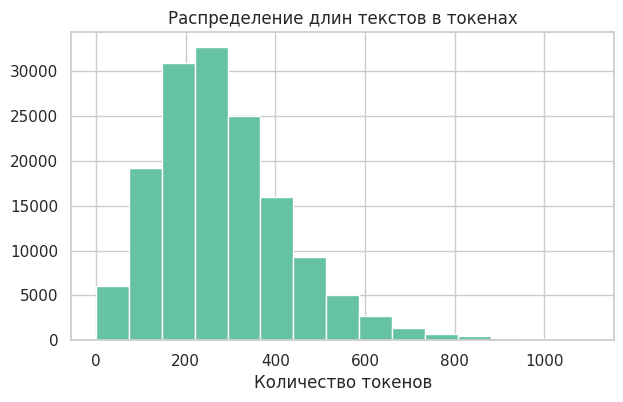

In [ ]:
lens = [len(row) for row in train_tokens]
print("Максимальная длина:", max(lens))

plt.figure(figsize=(7, 4))
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.hist(lens, bins=15, range=(0, 1100))
plt.show();

In [ ]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate
)

valid_loader = DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate
)

In [ ]:
class SimpleRNNRegressor(nn.Module):
    def __init__(
        self,
        num_tokens,
        emb_size=100,
        rnn_num_units=64,
        output_dim=1
    ):
        super(self.__class__, self).__init__()

        self.embedding = nn.Embedding(num_tokens, emb_size, padding_idx=PAD_IDX_EN)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.fc = nn.Linear(rnn_num_units, output_dim)

    def forward(self, x):
              embedded = self.embedding(x)
              predict = self.rnn(embedded)
              predictions = self.fc(h_state.squeeze(0))
              return predictions


In [ ]:
def mse(preds, y):
    """
    Возвращает среднеквадратичную ошибку модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные значения таргета.
    """

    return F.mse_loss(preds, y, reduction="mean")

In [ ]:


def train(model, iterator, optimizer, criterion, train_loss_history):
    epoch_loss = 0
    epoch_mse = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        optimizer.zero_grad()

        texts, target = batch
        texts, target = texts.to(device), target.to(device)

        predictions = model(texts)
        loss = criterion(predictions, target.float())
        mse = loss.item()

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mse += mse

    return epoch_loss / len(iterator), epoch_mse / len(iterator)


def evaluate(model, iterator, criterion, val_loss_history=None):
    epoch_loss = 0
    epoch_mse = 0
    model.eval()

    with torch.no_grad():
        for batch_id, batch in enumerate(iterator):
            texts, target = batch
            texts, target = texts.to(device), target.to(device)
            predictions = model(texts)
            loss = criterion(predictions, target)
            mse = loss.item()

            epoch_loss += loss.item()
            epoch_mse += mse

    return epoch_loss / len(iterator), epoch_mse / len(iterator)




def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:


def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float("inf")
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(
            model_instance, train_loader, optimizer, criterion, loss_history
        )
        acc_history.append(train_acc)

        # Оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(
            model_instance, valid_loader, criterion, val_loss_history
        )
        val_acc_history.append(valid_acc)

        # Посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Отрисуем значение точности от эпохи
        plt.subplot(1, 3, 3)
        plt.plot(acc_history, label="Train")
        plt.plot(val_acc_history, label="Valid")
        plt.legend()
        plt.title("Accuracy")
        plt.xlabel("Номер эпохи")
        plt.show()

        print(
            f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s"
        )



In [ ]:
model = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=100,
    rnn_num_units=128,
    output_dim=1,
).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
history = []

model

SimpleRNNRegressor(
  (embedding): Embedding(25002, 100, padding_idx=25001)
  (rnn): RNN(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([48, 1])) that is different to the input size (torch.Size([48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

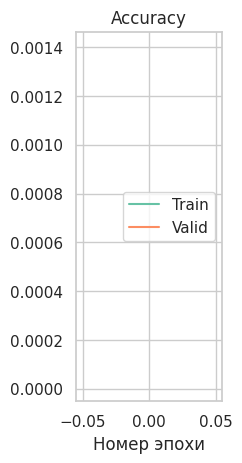

Номер эпохи: 01 | Время обучения эпохи: 0m 27s


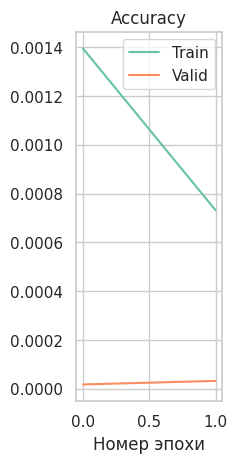

Номер эпохи: 02 | Время обучения эпохи: 0m 27s


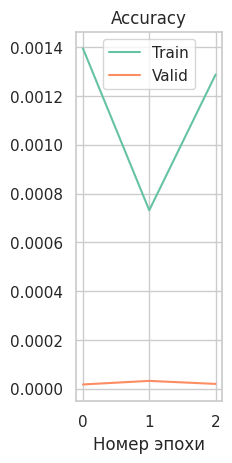

Номер эпохи: 03 | Время обучения эпохи: 0m 27s


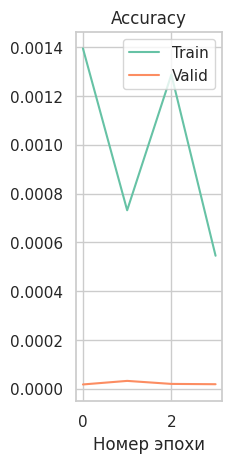

Номер эпохи: 04 | Время обучения эпохи: 0m 27s


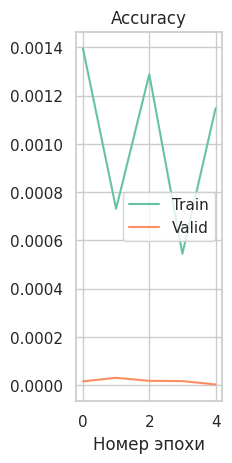

Номер эпохи: 05 | Время обучения эпохи: 0m 27s


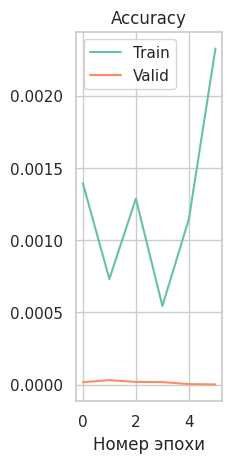

Номер эпохи: 06 | Время обучения эпохи: 0m 29s


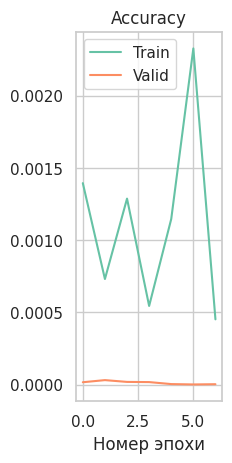

Номер эпохи: 07 | Время обучения эпохи: 0m 28s


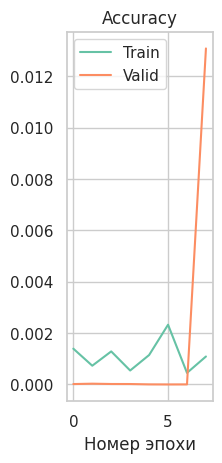

Номер эпохи: 08 | Время обучения эпохи: 0m 27s


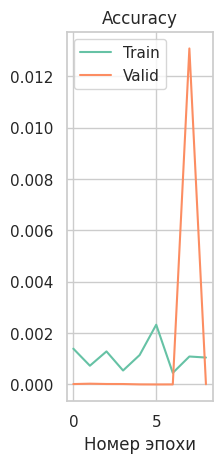

Номер эпохи: 09 | Время обучения эпохи: 0m 27s


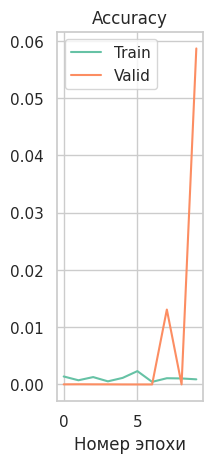

Номер эпохи: 10 | Время обучения эпохи: 0m 27s


In [ ]:
training_loop(model)


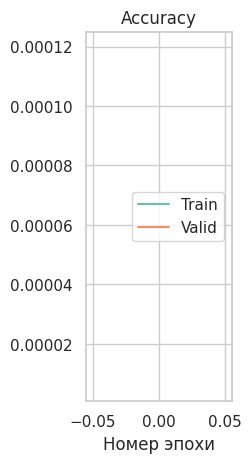

Номер эпохи: 01 | Время обучения эпохи: 0m 51s


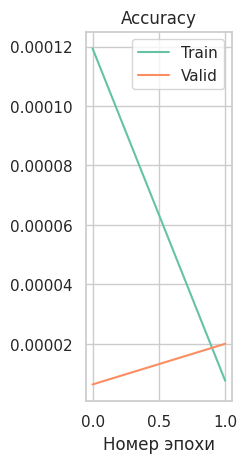

Номер эпохи: 02 | Время обучения эпохи: 0m 51s


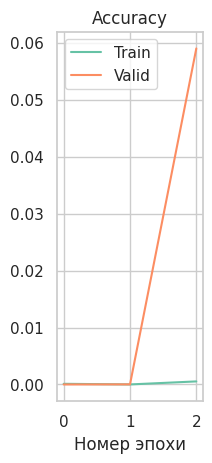

Номер эпохи: 03 | Время обучения эпохи: 0m 51s


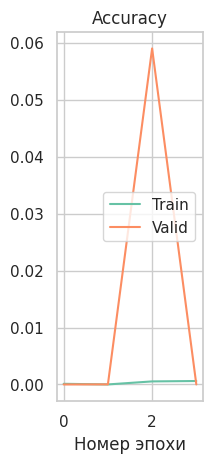

Номер эпохи: 04 | Время обучения эпохи: 0m 51s


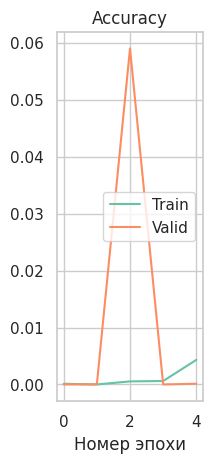

Номер эпохи: 05 | Время обучения эпохи: 0m 51s


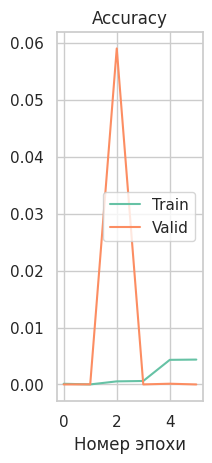

Номер эпохи: 06 | Время обучения эпохи: 0m 51s


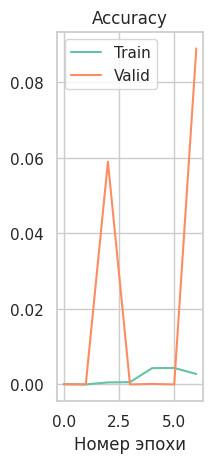

Номер эпохи: 07 | Время обучения эпохи: 0m 56s


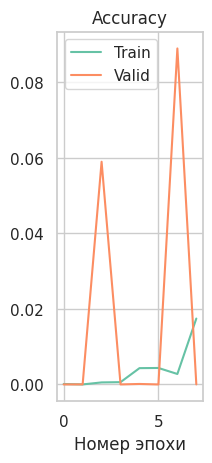

Номер эпохи: 08 | Время обучения эпохи: 0m 51s


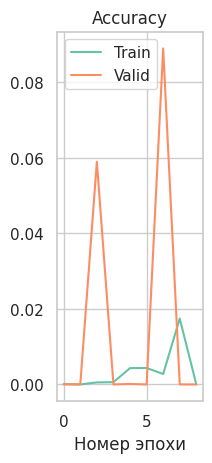

Номер эпохи: 09 | Время обучения эпохи: 0m 50s


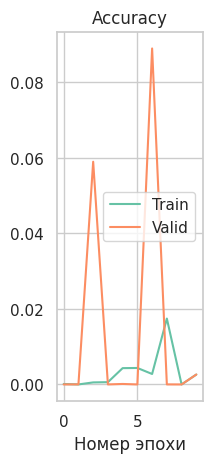

Номер эпохи: 10 | Время обучения эпохи: 0m 50s


In [ ]:
model2 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=64,
    rnn_num_units=256,
    output_dim=1,
).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
history = []
training_loop(model2)


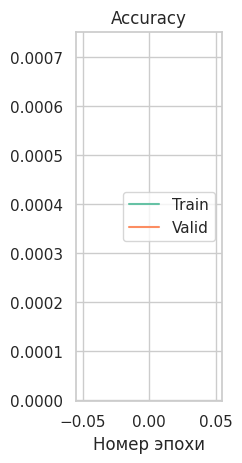

Номер эпохи: 01 | Время обучения эпохи: 0m 39s


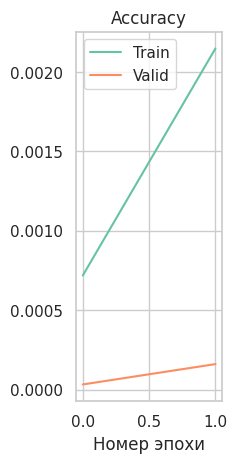

Номер эпохи: 02 | Время обучения эпохи: 0m 39s


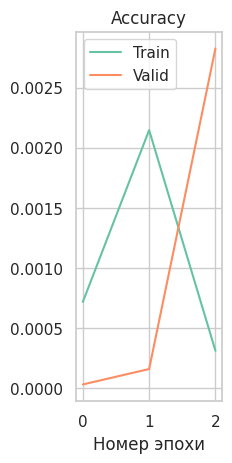

Номер эпохи: 03 | Время обучения эпохи: 0m 38s


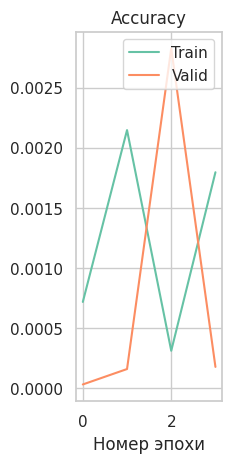

Номер эпохи: 04 | Время обучения эпохи: 0m 38s


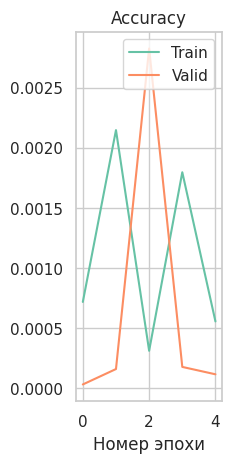

Номер эпохи: 05 | Время обучения эпохи: 0m 38s


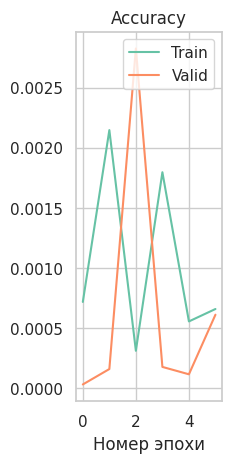

Номер эпохи: 06 | Время обучения эпохи: 0m 38s


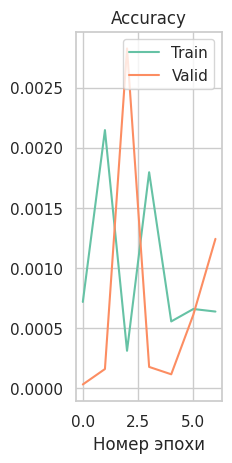

Номер эпохи: 07 | Время обучения эпохи: 0m 39s


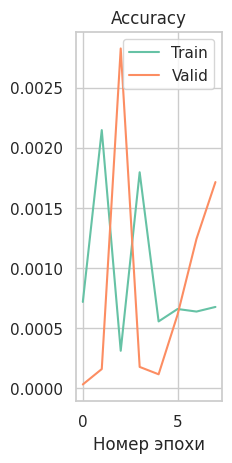

Номер эпохи: 08 | Время обучения эпохи: 0m 39s


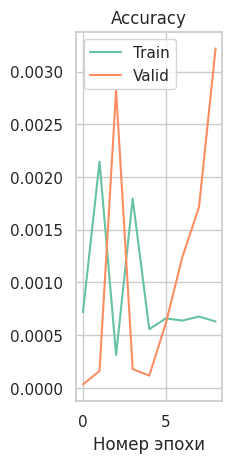

Номер эпохи: 09 | Время обучения эпохи: 0m 38s


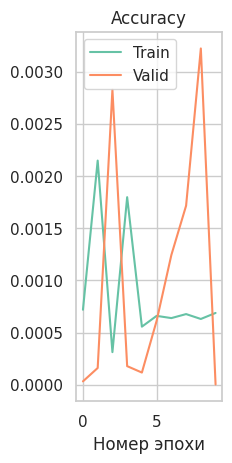

Номер эпохи: 10 | Время обучения эпохи: 0m 38s


In [ ]:
model3 = SimpleRNNRegressor(
    num_tokens=num_tokens,
    emb_size=300,
    rnn_num_units=128,
    output_dim=1,
).to(device)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.0075)
history = []

training_loop(model3)



In [ ]:
data_batch, labels_batch = next(iter(valid_loader))

# Применяем модель, получаем предсказания
with torch.no_grad():
    preds = model3(data_batch.to(device))

label_mapping = ["negative", "positive"]

# Выведем предсказания для 5 случайных примера из тестового батча
indices = torch.randint(low=0, high=len(data_batch), size=(5,))
for idx in indices:
    print("=" * 20)
    print("Text:")
    text = " ".join(
        [
            token
            for token in vocab.lookup_tokens(data_batch[idx].tolist())
            if token not in ["<unk>", "<pad>"]
        ]
    )
    print(text)
    print(f"Predicted Salary: {scaler.inverse_transform(torch.tensor(preds[idx].cpu()).reshape(-1, 1)).item():.2f}")
    print(f"True Salary: {scaler.inverse_transform(torch.tensor(labels_batch[idx].cpu()).reshape(-1, 1)).item():.2f}")
    print()

mse = mean_squared_error(true_salaries, predictions)
print("Mean Squared Error on Test Data:", mse)


Text:
result business growth looking strengthen provide detailed technical support standard packages contracts audits surveys product experience customer dealing role managing standard package projects surveys audits proven track record working similar business/ industry work pressure decision making skills skills skills attention detail able deal conflict learn roles share knowledge role provide appropriate responses technical commercial enquiries carrying reviews order processing progress documentation aspects associated managing contracts adaptable approach essential roles client operates within process steam industry previous experience would advantage essential apply position candidates must eligible live work acting relation vacancy
Predicted Salary: 5129.15
True Salary: 5000.00

Text:
looking take next step career proven track record leading nursing look clinical needs world wide client literally changed face elderly care last 10 years start clients showed different everybody el

<ipython-input-93-e02434646917>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Predicted Salary: {scaler.inverse_transform(torch.tensor(preds[idx].cpu()).reshape(-1, 1)).item():.2f}")
<ipython-input-93-e02434646917>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"True Salary: {scaler.inverse_transform(torch.tensor(labels_batch[idx].cpu()).reshape(-1, 1)).item():.2f}")
<ipython-input-93-e02434646917>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Predicted Salary: {scaler.inverse_transform(torch.tensor(preds

**Вывод:**
Можно заметить, то что ближе всего к нужному результату была третья модель. Можно заметить, что чем меньше learning rate, тем быстрее модель обучается, что и логично. Также с увеличением "embedding size" увеличивается точность модели, если сравнивать первую и третью модель